In [458]:
import tensorflow as tf
import numpy as np
import scipy
print(scipy.__version__)


1.13.1


In [459]:
TRAIN_DIR = "D:\Download\Wild_Edible_Plants\Train"
TEST_DIR = "D:\Download\Wild_Edible_Plants\Val"
METADATA = "D:\Download\Wild_Edible_Plants\edible wild plants metadata.xls"

In [460]:
import pandas as pd

# Membaca file metadata
metadata = pd.read_excel(METADATA)

# Melihat isi file
print(metadata.head())


   Nr                Name  # pics  Scientific name  \
0   9             Alfalfa      50  Medicago sativa   
1   5           Asparagus     100        Asparagus   
2  46        Blue Vervain      50  Verbena hastata   
3  10  Broadleaf Plantain      50   Plantago major   
4   8        Bull Thistle      50  Cirsium vulgare   

                                         Description  
0  A flowering plant in the pea family, Alfalfa i...  
1  Asparagus, easily identified by its fleshy gre...  
2  You should refrain from this plant if you are ...  
3  A species of the plantain family, Broadleaf Pl...  
4  You can identify this plant by its firm and th...  


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmen_train = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest',
    #validation_split=0.2
)

augmen_val = ImageDataGenerator(rescale=1./255)

train_generator = augmen_train.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(224, 224),
    #class_mode="categorical",
    batch_size=16,
    shuffle=True,
    subset="training",
    #seed=42
)

validation_generator = augmen_val.flow_from_directory(
    directory=TEST_DIR,
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=16,
    shuffle=False, 
    #subset="validation",
    #seed=42
)


Found 5247 images belonging to 62 classes.
Found 1311 images belonging to 62 classes.


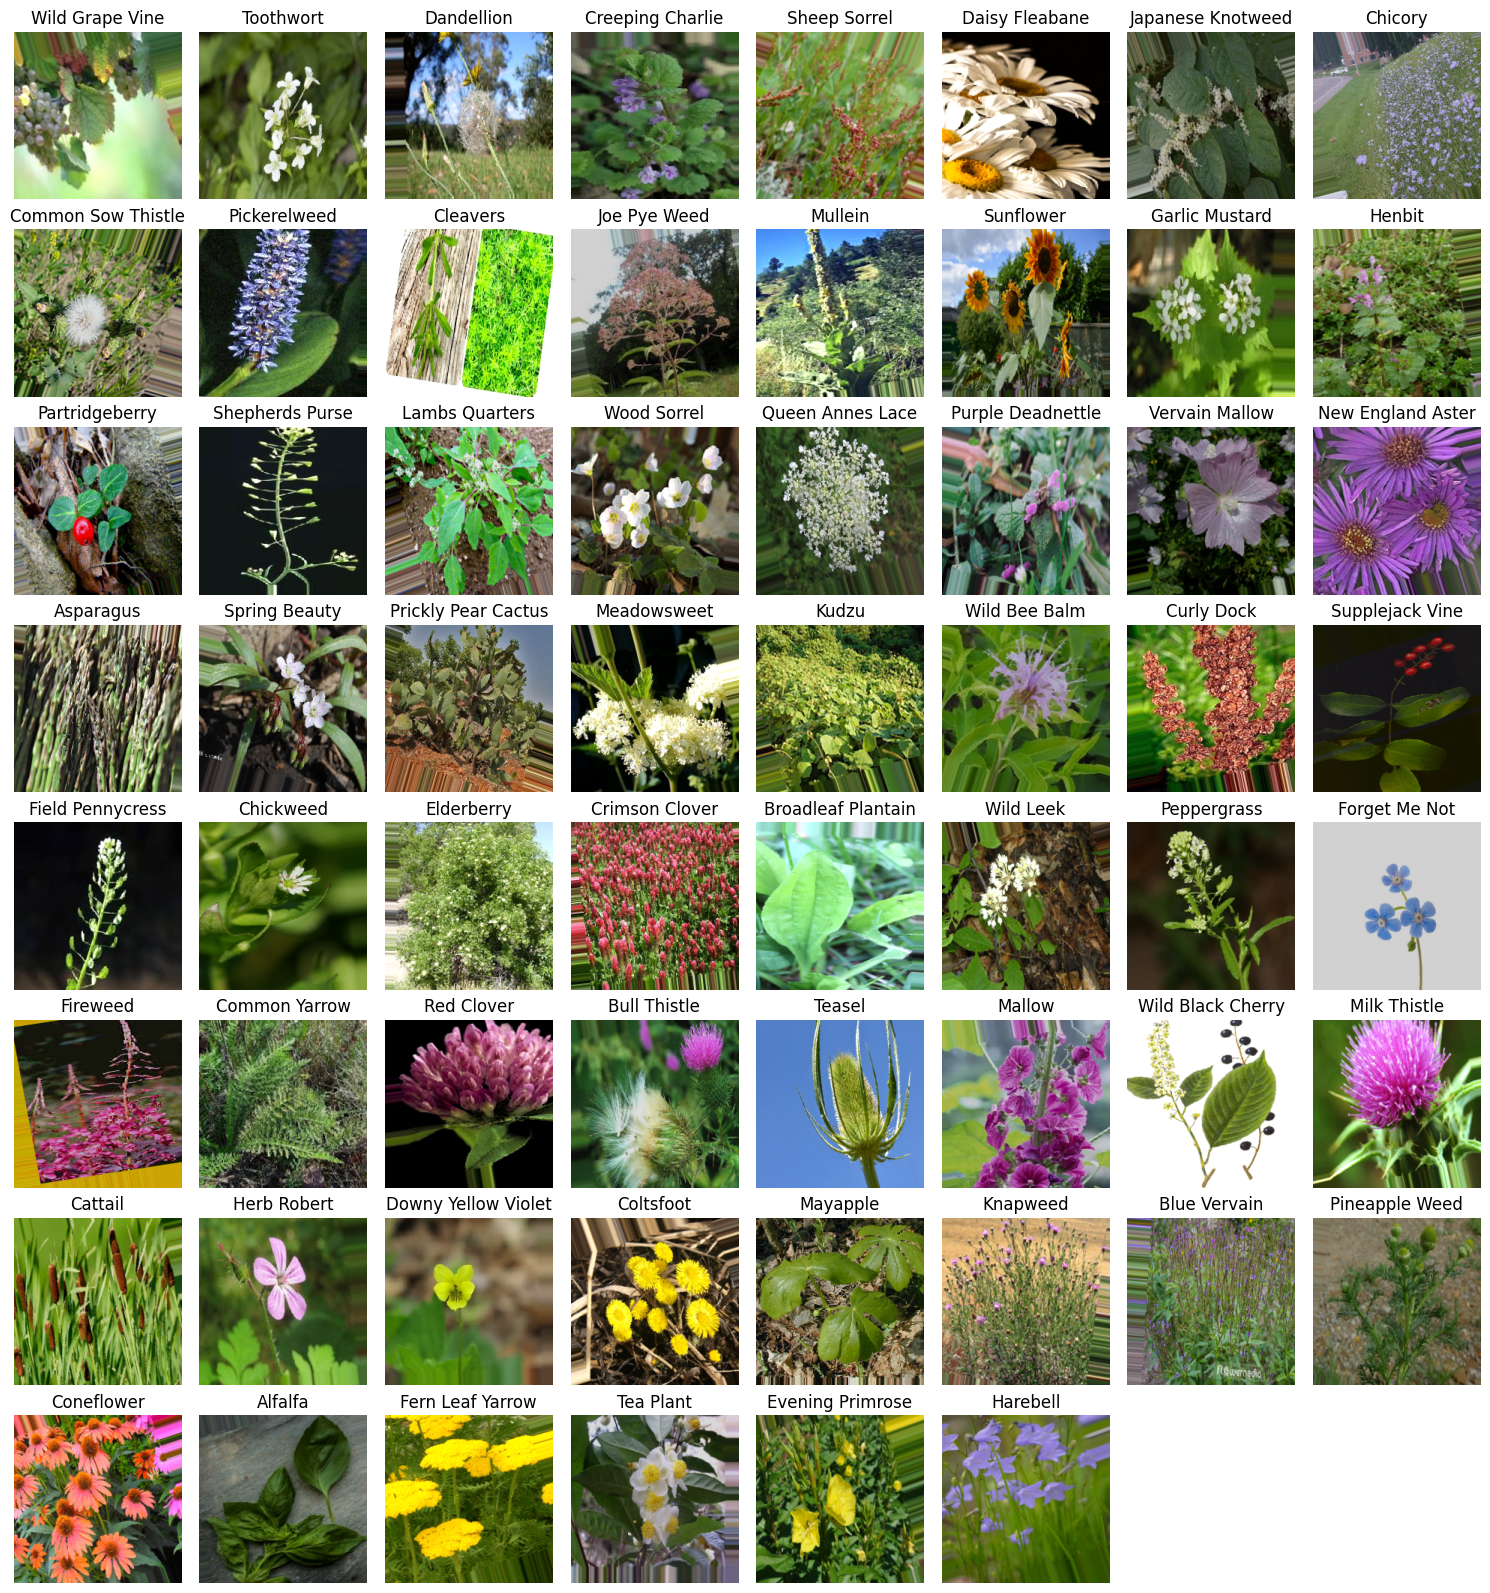

In [462]:
import matplotlib.pyplot as plt

class_names = list(train_generator.class_indices.keys())

train_generator.reset()

class_images = {}

while len(class_images) < len(class_names):
    images, labels = next(train_generator)
    for img, lbl in zip(images, labels):
        class_idx = lbl.argmax()
        class_name = class_names[class_idx]
        if class_name not in class_images:
            class_images[class_name] = img
            if len(class_images) == len(class_names):
                break

rows = 8
cols = (62 // rows) + 1 

plt.figure(figsize=(15, 2 * rows))
for i, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name)

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import ResNet50,InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.regularizers import l2

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#for layer in base_model.layers:
#    layer.trainable = False
    
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
#    Dense(256, activation='relu', kernel_regularizer=l2(0.02)),
#    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.4),
    Dense(62, activation='softmax', kernel_regularizer=l2(0.02))
 
])

model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_36  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_3710 (B  (None, 2048)             8192      
 atchNormalization)                                              
                                                                 
 dense_70 (Dense)            (None, 128)               262272    
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_71 (Dense)            (None, 62)              

In [464]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 224, 224, 3)
Output shape: (None, 62)


In [465]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [466]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
328/328 [==============================] - 146s 402ms/step - loss: 6.5652 - accuracy: 0.3905 - val_loss: 3.9179 - val_accuracy: 0.5278
Epoch 2/30
328/328 [==============================] - 64s 196ms/step - loss: 3.2933 - accuracy: 0.5182 - val_loss: 2.5518 - val_accuracy: 0.6011
Epoch 3/30
328/328 [==============================] - 61s 187ms/step - loss: 2.5177 - accuracy: 0.5771 - val_loss: 2.1928 - val_accuracy: 0.6240
Epoch 4/30
328/328 [==============================] - 58s 178ms/step - loss: 2.2932 - accuracy: 0.5904 - val_loss: 2.0556 - val_accuracy: 0.6468
Epoch 5/30
328/328 [==============================] - 59s 179ms/step - loss: 2.1436 - accuracy: 0.6192 - val_loss: 2.0480 - val_accuracy: 0.6384
Epoch 6/30
328/328 [==============================] - 59s 180ms/step - loss: 2.0774 - accuracy: 0.6364 - val_loss: 1.9932 - val_accuracy: 0.6423
Epoch 7/30
328/328 [==============================] - 62s 189ms/step - loss: 2.0021 - accuracy: 0.6427 - val_loss: 1.9832 - val_a

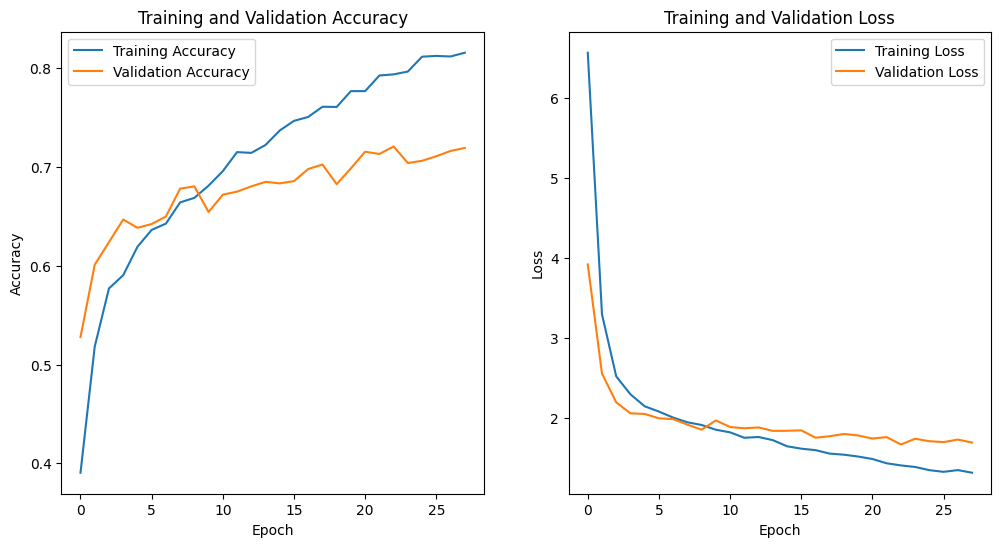

In [467]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [468]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)

print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")


82/82 [==============================] - 5s 65ms/step - loss: 1.6657 - accuracy: 0.7208
Training Accuracy: 0.8992, Validation Accuracy: 0.7208


In [469]:
model.save('survplant_model.h5', save_format='h5')

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import os

image_size = 224 

model = tf.keras.models.load_model('D:\OneDrive\Dokumen\Bangkit Academy\survplant_model(acc80 overvitt).h5')

USER_IMAGE_DIR = "D:\Download\Wild_Edible_Plants\datasets\dataset-user_images"

class_names = list(train_generator.class_indices.keys())

for img_file in os.listdir(USER_IMAGE_DIR):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(USER_IMAGE_DIR, img_file)

        # Load gambar dan preprocessing
        img = image.load_img(img_path, target_size=(image_size, image_size))
        img_array = image.img_to_array(img) / 255.0  
        img_array = np.expand_dims(img_array, axis=0) 

        # Prediksi
        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions)]
        confidence = np.max(predictions)

        print(f"Gambar: {img_file}")
        print(f"Prediksi: {predicted_class} (Confidence: {confidence:.2f})\n")


1/1 [==============================] - 2s 2s/step
Gambar: Alfalfa.jpg
Prediksi: Knapweed (Confidence: 0.63)

1/1 [==============================] - 0s 32ms/step
Gambar: Alfalfa2.jpg
Prediksi: Wild Bee Balm (Confidence: 0.08)

1/1 [==============================] - 0s 31ms/step
Gambar: Asparagus.jpg
Prediksi: Asparagus (Confidence: 0.60)

1/1 [==============================] - 0s 33ms/step
Gambar: Beavis_and_butt_head.jpg
Prediksi: Daisy Fleabane (Confidence: 0.98)

1/1 [==============================] - 0s 31ms/step
Gambar: Blue_Vervain.jpg
Prediksi: Blue Vervain (Confidence: 0.96)

1/1 [==============================] - 0s 32ms/step
Gambar: Broadleaf_plantain.jpg
Prediksi: Broadleaf Plantain (Confidence: 1.00)

1/1 [==============================] - 0s 32ms/step
Gambar: Chicory.jpg
Prediksi: Chicory (Confidence: 0.97)

1/1 [==============================] - 0s 28ms/step
Gambar: crimson_clover.jpeg
Prediksi: Crimson Clover (Confidence: 0.95)

1/1 [==============================] - 0s 2